In [86]:
import numpy as np

import pandas as pd

from sklearn import svm
from sklearn.preprocessing import StandardScaler

import os

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

### 1. Data set

In [105]:
from torch.utils.data import random_split

NUM_PROLIFIC_AUTHORS = 100

class CustomDataset(Dataset):
    def __init__(self, file_name, data_dir, transform=None, target_transform=None):
        self.data_dir = data_dir
        
        self.data = pd.read_json(os.path.join(data_dir, file_name))
        self.data = self.data.applymap(lambda x: -1 if x == '' else x) # Change null data to -1
        
        self.x = self.data.drop(columns=['authors']).values
        self.y = self.data.authors.values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x_fixed = self.x[idx,[0, 2]].astype(np.int32)
        x_abstract = self.x[idx,1]
        x_title = self.x[idx,3]
        y = np.array(self.y[idx])
        y = self.authors_to_one_hot(y)

        return x_fixed, y # x_abstract, x_title, y

    def authors_to_one_hot(self, a):
        one_hot = np.zeros(NUM_PROLIFIC_AUTHORS).astype(int)
        a = np.array(a)
        a = a[a < 100]
        one_hot[a] = 1
        return one_hot

dataset = CustomDataset('train.json', './data/')
train_set, val_set = random_split(dataset, [round(len(dataset)*0.7), round(len(dataset)*0.3)])
train_dataloader = DataLoader(train_set, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=128, shuffle=True)

# for _ in range(5):
#     _, _, _, y = next(iter(train_dataloader))
#     print(y)

### 2. Model

NN

In [90]:
import torch.nn.functional as F

HIDDEN_DIM1 = 256
HIDDEN_DIM2 = 100

class MultilayerPerceptronModel(nn.Module):
    def __init__(self, n_features, n_classes, hidden_dim1 = HIDDEN_DIM1, hidden_dim2 = HIDDEN_DIM2):
        super().__init__()
        
        self.input_layer = nn.Linear(n_features, hidden_dim1)
        self.hidden_layer = nn.Linear(hidden_dim1, hidden_dim2)
        self.output_layer = nn.Linear(hidden_dim2, n_classes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        batch_size = x.shape[0]
        
        x = x.view(batch_size, -1)  # Flatten image into vector, retaining batch dimension
        
        x = F.relu(self.input_layer(x))
        x = self.dropout(x)
        
        x = F.relu(self.hidden_layer(x))
        x = self.dropout(x)
        
        out = F.sigmoid(self.output_layer(x))
        
        return out

In [103]:
import time
from tkinter import Y

def test(model, criterion, test_loader):
    test_loss = 0.
    test_preds, test_labels = list(), list()
    for i, data in enumerate(test_loader):
        x_fixed, y = data
        x_fixed = x_fixed.float()
        y = y.float()

        with torch.no_grad():
            logits = model(x_fixed)
            predictions = torch.round(logits)
            test_loss += criterion(input=logits, target=y).item()
            test_preds.append(predictions)
            test_labels.append(y)

    test_preds = torch.cat(test_preds)
    test_labels = torch.cat(test_labels)

    test_accuracy = torch.mean((torch.sum(torch.eq(predictions, y).float(), 1) == 100).float()).item()

    print('[TEST] Mean loss {:.4f} | Accuracy {:.4f}'.format(test_loss/len(test_loader), test_accuracy))

def train(model, train_loader, val_loader, optimizer, n_epochs=10):
    """
    Generic training loop for supervised multiclass learning
    """
    LOG_INTERVAL = 250
    running_loss, running_accuracy = list(), list()
    start_time = time.time()
    criterion = torch.nn.BCELoss()

    for epoch in range(n_epochs):  # Loop over training dataset `n_epochs` times

        epoch_loss = 0.

        for i, data in enumerate(train_loader):  # Loop over elements in training set

            x_fixed, y = data
            x_fixed = x_fixed.float()
            y = y.float()
            
            logits = model(x_fixed)


            predictions = torch.round(logits)
            # print(f'{torch.mean((torch.sum(torch.eq(predictions, y).float(), 1) == 100).float())}\n')
            train_acc = torch.mean((torch.sum(torch.eq(predictions, y).float(), 1) == 100).float()).item()

            # print(logits)
            loss = criterion(input=logits, target=y)

            loss.backward()               # Backward pass (compute parameter gradients)
            optimizer.step()              # Update weight parameter using SGD
            optimizer.zero_grad()         # Reset gradients to zero for next iteration


            # ============================================================================
            # You can safely ignore the boilerplate code below - just reports metrics over
            # training and test sets

            running_loss.append(loss.item())
            running_accuracy.append(train_acc)

            epoch_loss += loss.item()

            if i % LOG_INTERVAL == 0:  # Log training stats
                deltaT = time.time() - start_time
                mean_loss = epoch_loss / (i+1)
                print('[TRAIN] Epoch {} [{}/{}]| Mean loss {:.4f} | Current Mean train accuracy {:.5f} | Current data accuracy {:.5f} | Time {:.2f} s'.format(epoch, 
                    i, len(train_loader), mean_loss, sum(running_accuracy)/len(running_accuracy), train_acc, deltaT))

        print('Epoch complete! Mean loss: {:.4f}'.format(epoch_loss/len(train_loader)))

        test(model, criterion, val_loader)
        
    return running_loss, running_accuracy

In [106]:
NUM_FEATURES_FIXED = 2

mlp_model = MultilayerPerceptronModel(NUM_FEATURES_FIXED, NUM_PROLIFIC_AUTHORS)
optimizer = torch.optim.SGD(mlp_model.parameters(), lr=1e-2, momentum=0.9)
# optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-2)
mlp_loss, mlp_acc = train(mlp_model, train_dataloader, val_dataloader, optimizer)

RuntimeError: each element in list of batch should be of equal size

Text(0, 0.5, 'Cross-entropy Loss (Train)')

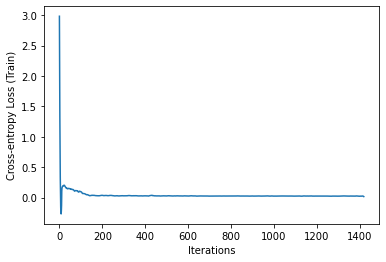

In [100]:
from scipy.signal import savgol_filter  # Smooth spiky curves
import matplotlib.pyplot as plt
running_loss_smoothed = savgol_filter(mlp_loss, 21, 3)
running_acc_smoothed = savgol_filter(mlp_acc, 21, 3)

plt.plot(running_loss_smoothed)
plt.xlabel('Iterations')
plt.ylabel('Cross-entropy Loss (Train)')

(0.2, 1.0)

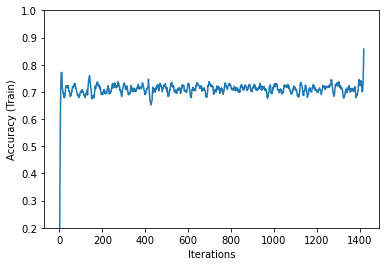

In [101]:
plt.plot(running_acc_smoothed)
plt.xlabel('Iterations')
plt.ylabel('Accuracy (Train)')
plt.ylim(0.2,1.)

RNN

In [2]:
import torch.nn as nn
import torch.optim as optim

In [ ]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size) 
        self.activation = nn.Tanh() 
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.activation(self.i2h(combined)) 
        output = self.h2o(hidden) 
        output = self.softmax(output)
        return output, hidden
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample(noise=0, noise_chars=".,;'"):
    # noise: integer denoting the maximum number of distractor characters to add
    # noise_chars: inventory of distractor characters
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    # added code to insert distracting nonsense into the string
    if noise > 0:
        line_prime = line
        for i in range(random.randint(0, noise+1)):
            line_prime += random.choice(noise_chars)
        line = line_prime
    # end change
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [ ]:


n_iters = 80000
print_every = 5000
plot_every = 1000
noise_level = 0 # change this line (as discussed later)
n_hidden = 32
learning_rate = 0.005

current_loss = 0
all_losses = []

rnn = RNNClassifier(n_letters, n_hidden, n_categories)
criterion = nn.NLLLoss()

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
start = time.time()

# training algorithm, which takes one instance and performs single SGD update
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    # key step: unroll the RNN over each symbol in the input sequence
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    # treat the last output as the prediction of the category label
    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss.item()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample(noise=noise_level)
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

In [ ]:
class AttentionalGRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(AttentionalGRUClassifier, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size) 
        self.att = nn.Linear(hidden_size, 1) 
        
    def forward(self, input_sequence):
        # process the input sequence into a sequence of RNN hidden states
        states, _ = self.gru(input_sequence)
        # compute attention scores to each RNN hidden state (we use a linear function)
        att_scores = self.att(states)
        # rescale the attention scores using a softmax, so they sum to one
        alpha = F.softmax(att_scores, dim=0)
        # compute the "c" vector as a weighted combination of the RNN hidden states
        c = torch.sum(torch.mul(states, alpha), dim=0)
        # now couple up the c state to the output, and compute log-softmax
        output = self.h2o(c.view(1, -1)) 
        output = F.log_softmax(output, dim=1)
        return output, alpha

In [ ]:


model = AttentionalGRUClassifier(n_letters, n_hidden, n_categories)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

start = time.time()
all_losses_att = []
current_loss = 0

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample(noise=noise_level)

    model.zero_grad()
    output, _ = model.forward(line_tensor)
    output = torch.squeeze(output, 1) # remove redundant dimension
    loss = criterion(output, category_tensor)
    current_loss += loss.item()
    loss.backward()
    optimizer.step()

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses_att.append(current_loss / plot_every)
        current_loss = 0